In [1]:
import os, sys, re
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.style.use('ggplot')

# EDA библиотеки
import statistics as stcs
import statsmodels.stats.proportion as stsmdls

# библиотека для расчетов корреляций
from scipy import stats

# библиотека для кодирования признаков
import category_encoders as ce

# для обработки timestamp в формате utc
import datetime, time

# выводить все результаты вычислений в ячейках Code
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# подключить Latex
from IPython.display import Latex

# изменить формат вывода pandas
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
# pd.set_option('display.max_info_rows', 500)
# pd.set_option('display.max_info_columns', 500)
# pd.set_option('display.width', 1000)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.large_repr', 'truncate')

## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [3]:
# читаем dataframe и создаём копию
df = pd.read_csv('./data/ab_data_tourist.csv')
data = df.copy()

# знакомимся с данными
data.head(10)

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000
5,936923,2021-01-10,A,0,0
6,679687,2021-01-19,B,1,10000
7,719014,2021-01-17,A,0,0
8,817355,2021-01-04,B,1,60000
9,839785,2021-01-15,B,1,10000


### **Признаки**

* *user_id* - идентификатор пользователя, зашедшего на сайт;

* *date* - дата захода;

* *group* - группа теста (контрольная — А или тестовая — B);

* *purchase* - признак покупки: совершил ли пользователь покупку тура (1 — да, 0 — нет);

* *price* - цена купленного тура (если покупка не состоялась, цена равна 0).

## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [4]:
# сводный вывод данных о типах
data.info()
print()

# конкретизируем тип данных
print(f"Точный тип данных в признаке 'date' - {type(data['date'][0])}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB

Точный тип данных в признаке 'date' - <class 'str'>


### **Выводы 7.1:**

Изначально признак **date** типа '*object*', а конкретнее - '***str***'.

---

## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [5]:
# переводим даты в формат datetime по шаблону YYYY-MM-DD
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

# ответ на вопрос когда проводился A/B-тест
print(f'Начало теста: \n' \
    f"{data.groupby(['group'])['date'].agg('min')}\n")

print(f'Конец теста: \n' \
    f"{data.groupby(['group'])['date'].agg('max')}\n")


# data.groupby(by=['group'])['date'].agg(['min', 'max'])

Начало теста: 
group
A   2021-01-02
B   2021-01-02
Name: date, dtype: datetime64[ns]

Конец теста: 
group
A   2021-01-24
B   2021-01-24
Name: date, dtype: datetime64[ns]



### **Выводы 7.2:**

Начальные и конечные даты проведения A/B-теста для обеих групп совпадают.

---

## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [6]:
print(f'Количество посещений сайта в группах А и B: \n' \
    f"{data.groupby(by=['group'])['user_id'].agg('count')}\n")

print(f'Суммарное количество покупок в группах А и B: \n' \
    f"{data.groupby(by=['group'])['purchase'].agg('sum')}\n")

print(f'Сумма всех покупок в группах А и B, млн. руб.: \n' \
    f"{data.groupby(by=['group'])['price'].agg('sum') / 1e6}\n")

Количество посещений сайта в группах А и B: 
group
A    147202
B    147276
Name: user_id, dtype: int64

Суммарное количество покупок в группах А и B: 
group
A    17723
B    17514
Name: purchase, dtype: int64

Сумма всех покупок в группах А и B, млн. руб.: 
group
A    1436.26
B    1554.10
Name: price, dtype: float64



### **Выводы 7.3:**

По предварительным данным, группа **B** по сравнению с группой **A**:
* **имеет больше посещений сайта**;
* меньшее число суммарных покупок;
* **значительно большую сумму покупок** в денежном эквиваленте (почти 120 млн. руб.)

Исходя из этого, заранее предположу, что <font color='LightSeaGreen'>**средние затраты (средний чек) в группе B выше**</font>, чем в группе **A**.

---

## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [7]:
# создаём множества
set_users_A = set(data[data['group'] == 'A']['user_id'])
set_users_B = set(data[data['group'] == 'B']['user_id'])

# пересекаем множества
user_intersection = set_users_A.intersection(set_users_B)

# выводим длину получившегося множества
print(f'{len(user_intersection)} пользователей попали в обе группы')

1895 пользователей попали в обе группы


## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [8]:
# исключаем пользователей
data = data[data['user_id'].apply(lambda x: x not in user_intersection)]
data.reset_index(inplace=True)

Где user_intersection - множество пересечений пользователей групп А и B.

In [9]:
# проверка данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290688 entries, 0 to 290687
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   index     290688 non-null  int64         
 1   user_id   290688 non-null  int64         
 2   date      290688 non-null  datetime64[ns]
 3   group     290688 non-null  object        
 4   purchase  290688 non-null  int64         
 5   price     290688 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 13.3+ MB


### **Выводы 7.4:**

1895 пользователей - погрешность, которую исключили. Составляет в процентном соотношении **1.29% для группы A и B**, соответственно.

---

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

| <center>group | <center>count_visits | <center>count_purchases | <center>sum_price |
| --- | --- | --- | --- |
| <center>A | <center>? | <center>? | <center>? |
| <center>B | <center>? | <center>? | <center>? |

Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?

In [10]:
# формирование датафрейма с агрегированными показателями
grouped = data.groupby(by=['group']
    ).agg({
        'user_id':'count',
        'purchase':'sum',
        'price':'sum'
        }).reset_index().rename(
            columns={
                'user_id': 'count_visits',
                'purchase': 'count_purchases',
                'price': 'sum_price',
                })

# проверка данных
grouped.head()

,group,count_visits,count_purchases,sum_price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

### **Выводы 7.5:**

* **Число уникальных посещений сайта примерно равно**, разница между группами составляет 74 пользователя;
* Количество совершенных покупок между группами также незначительно уменьшилось, для группы **A** - 236, группы **B** - 224 покупки;
* Сумма покупок уменьшилась на чуть более 2,5 млн. руб. (~ 2,61 млн. руб.)

Касательно количества посещений, можно сказать, что <font color='LightSeaGreen'>**выборка сбалансирована, количество сопоставимо**</font>, а минимальная разница пройдет как статистическая погрешность (допуск), так как разница в уникальных посещениях между группами составляет 0,0254% !

---

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [11]:
# добавление новых признаков
grouped['conversion'] = grouped['count_purchases'] / grouped['count_visits'] * 100
grouped['mean_check'] = grouped['sum_price'] / grouped['count_purchases']
grouped

# ответы на вопросы
print(f"Конверсия в группе A: {grouped['conversion'][0].__round__(2)}%")
print(f"Конверсия в группе B: {grouped['conversion'][1].__round__(2)}%")
print(f"Средний чек в группе A: {grouped['mean_check'][0].__round__()} руб.")
print(f"Средний чек в группе B: {grouped['mean_check'][1].__round__()} руб.")

,group,count_visits,count_purchases,sum_price,conversion,mean_check
0,A,145307,17487,1417780000,12.034520,81076.228055
1,B,145381,17290,1533010000,11.892888,88664.545980


Конверсия в группе A: 12.03%
Конверсия в группе B: 11.89%
Средний чек в группе A: 81076 руб.
Средний чек в группе B: 88665 руб.


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

### **Выводы 7.6:**

**При переходе на вариант В**:
* <font color='Tomato'>**Конверсия сайта незначительно ухудшится**</font> на ~ 0,14%. Конверсия в группе **А** больше;
* <font color='LightSeaGreen'>**Вырастет средний чек, и при том, довольно существенно**</font>, разница между группами составляет чуть менее 10% (~ 8,67%), в числовом выражении - чуть более 7,5 тыс. руб. (~ 7589 руб.).

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [12]:
# оставляем в данных только строки с покупками (конверсией)
purchase_mask = data['purchase'] == 1

# формирование датафрейма
heat_data = data[purchase_mask].pivot_table(
    values='purchase',
    index='group',
    columns='price',
    aggfunc='count'
)

# проверка данных
heat_data

price,10000,60000,100000,150000,200000
group,,,,,
A,5182,5271,1832,3478,1724
B,5201,1730,5227,3438,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

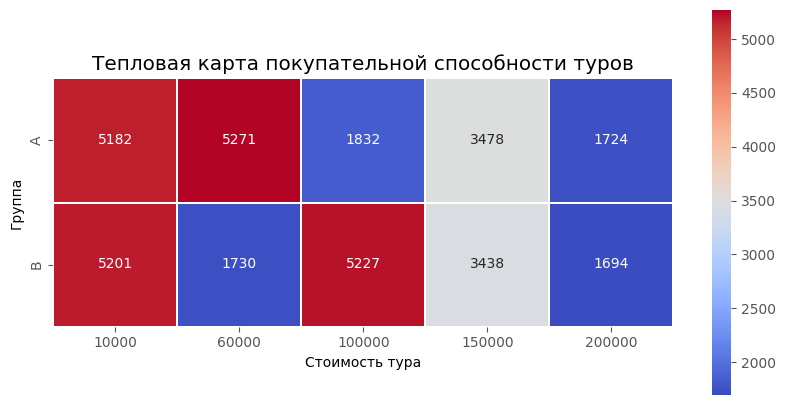

In [13]:
# формируем полотно
fig, ax = plt.subplots(figsize=(10, 5))

# строим график
heatmap = sns.heatmap(
    data=heat_data, 
    annot=True, 
    fmt='d',
    cmap='coolwarm', 
    square=True,
    linewidths=0.1,
    ax=ax
)

# меняем подписи осей и заголовок графика
ax.set(
    xlabel='Стоимость тура',
    ylabel='Группа',
    title='Тепловая карта покупательной способности туров'
);

In [14]:
# ответы ны вопросы
print(f'Количество проданных туров за 60000 рублей (Турция) в группе A: ' \
    f"{heat_data[60000].loc['A']}")
print(f'Количество проданных туров за 60000 рублей (Турция) в группе B: ' \
    f"{heat_data[60000].loc['B']}");

Количество проданных туров за 60000 рублей (Турция) в группе A: 5271
Количество проданных туров за 60000 рублей (Турция) в группе B: 1730


Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

### **Выводы 7.7:**

* **Конверсия**, примерно, **идентична в обеих группах в рамках самых недорогих и самых дорогих направлений**:
    * Санкт-Петербург (10000),
    * Камчатка (150000),
    * Мальдивы (200000)
    
    <br>
* Если взглянуть **на средне-ценовую категорию, то здесь предпочтения диаметрально противоположно различаются**, но в, примерно, одинаковых пропорциях:
    * В группе **A** больше направлений в Турцию (60000);
    * В группе **B** больше направлений в Тайланд (100000).

<font color='LightSeaGreen'>**Отсюда и следует повышенный средний чек в группе B**</font>.

---

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [15]:
# формируем датафрейм с ежедневными метриками
data_daily = data.groupby(by=['date', 'group']
    ).agg({
        'user_id':'count',
        'purchase':'sum',
        'price':'sum'
        }).reset_index().rename(
            columns={
                'user_id': 'count_visits',
                'purchase': 'sum_purchases',
                'price': 'sum_price'
                })

data_daily['conversion'] = data_daily['sum_purchases'] / data_daily['count_visits'] * 100
data_daily['mean_check'] = data_daily['sum_price'] / data_daily['sum_purchases']

# проверка данных
data_daily.head(4)

# задаём маски
mask_date = data_daily['date'] == '2021-01-03'
mask_grp_A = data_daily['group'] == 'A'
mask_grp_B = data_daily['group'] == 'B'

# ответы на вопросы
print(f'Конверсия на 03-01-2021 в группе A: ' \
    f"{data_daily[mask_date].loc[mask_grp_A]['conversion'].values[0].__round__(2)}%")

print(f'Конверсия на 03-01-2021 в группе B: ' \
    f"{data_daily[mask_date].loc[mask_grp_B]['conversion'].values[0].__round__(2)}%")

print(f'Средний чек на 03-01-2021 в группе A: ' \
    f"{data_daily[mask_date].loc[mask_grp_A]['mean_check'].values[0].__round__()} руб.")

print(f'Средний чек на 03-01-2021 в группе B: ' \
    f"{data_daily[mask_date].loc[mask_grp_B]['mean_check'].values[0].__round__()} руб.")

,date,group,count_visits,sum_purchases,sum_price,conversion,mean_check
0,2021-01-02,A,2854,359,29410000,12.578837,81922.005571
1,2021-01-02,B,2861,345,29660000,12.058721,85971.014493
2,2021-01-03,A,6596,748,62000000,11.340206,82887.700535
3,2021-01-03,B,6619,754,65960000,11.391449,87480.106101


Конверсия на 03-01-2021 в группе A: 11.34%
Конверсия на 03-01-2021 в группе B: 11.39%
Средний чек на 03-01-2021 в группе A: 82888 руб.
Средний чек на 03-01-2021 в группе B: 87480 руб.


### **Выводы 7.8:**

* Конверсия, примерно, идентична в обеих группах;
* Заметна <font color='LightSeaGreen'>**сильная разница в среднем чеке - заметно больше в группе B**</font>, более, чем на 5% (~ 5,29%).

---

## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [16]:
# формируем кумулятивные признаки
data_daily['cum_visits'] = data_daily.groupby(['group'])['count_visits'].cumsum()
data_daily['cum_purchases'] = data_daily.groupby(['group'])['sum_purchases'].cumsum()
data_daily['cum_price'] = data_daily.groupby(['group'])['sum_price'].cumsum()

# формируем кумулятивную конверсию и кумулятивный средний чек
data_daily['cum_conversion'] = data_daily['cum_purchases'] / data_daily['cum_visits'] * 100
data_daily['cum_mean_check'] = data_daily['cum_price'] / data_daily['cum_purchases']

# проверка данных
data_daily.head(4)

# задаём маски
mask_B_date = data_daily['date'] == '2021-01-20'
mask_A_date = data_daily['date'] == '2021-01-12'

# ответы на вопросы
print(f'Кумулятивная конверсия на 20-01-2021 в группе B: ' \
    f"{data_daily[mask_B_date]['cum_conversion'].values[1].__round__(2)}%"
)
print(f'Кумулятивный средний чек на 12-01-2021 в группе A: ' \
    f"{data_daily[mask_A_date]['cum_mean_check'].values[0].__round__()} руб."
)

,date,group,count_visits,sum_purchases,sum_price,conversion,mean_check,cum_visits,cum_purchases,cum_price,cum_conversion,cum_mean_check
0,2021-01-02,A,2854,359,29410000,12.578837,81922.005571,2854,359,29410000,12.578837,81922.005571
1,2021-01-02,B,2861,345,29660000,12.058721,85971.014493,2861,345,29660000,12.058721,85971.014493
2,2021-01-03,A,6596,748,62000000,11.340206,82887.700535,9450,1107,91410000,11.714286,82574.525745
3,2021-01-03,B,6619,754,65960000,11.391449,87480.106101,9480,1099,95620000,11.592827,87006.369427


Кумулятивная конверсия на 20-01-2021 в группе B: 11.9%
Кумулятивный средний чек на 12-01-2021 в группе A: 81492 руб.


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

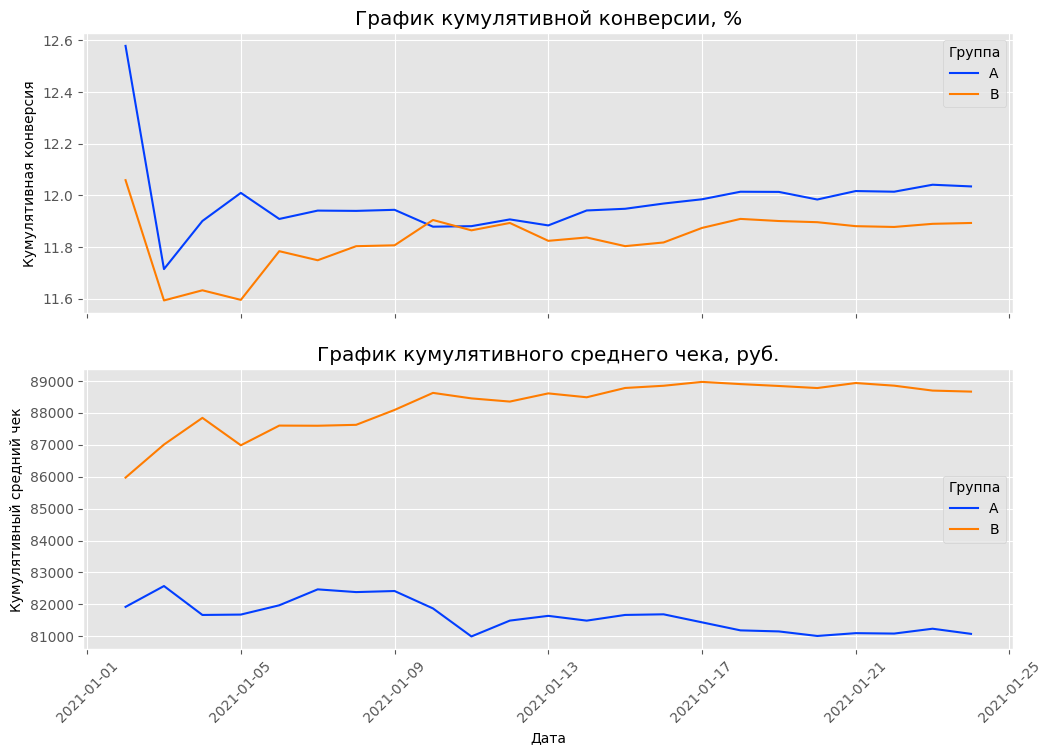

In [17]:
# задаём полотно
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex='row')

# строим графики
sns.lineplot(
    data=data_daily,
    x='date',
    y='cum_conversion',
    hue='group',
    ax=ax[0],
    palette='bright'
)
sns.lineplot(
    data=data_daily,
    x='date',
    y='cum_mean_check',
    hue='group',
    ax=ax[1],
    palette='bright'
)

# меняем подписи осей, заголовок графика, легенду
ax[0].legend(title='Группа')
ax[0].set(xticklabels=[], xlabel='', ylabel='Кумулятивная конверсия', title='График кумулятивной конверсии, %')
ax[0].grid(True)

ax[1].legend(title='Группа', loc='center right')
ax[1].set(xlabel='Дата', ylabel='Кумулятивный средний чек' , title='График кумулятивного среднего чека, руб.')
ax[1].grid(True);
ax[1].xaxis.set_tick_params(rotation=45);

### **Выводы 7.9:**

* <font color='Tomato'>***Считать тест А/В завершённым нельзя, потому что ещё не проведён анализ результатов с помощью статистических тестов***</font> и поэтому принимать окончательное решение преждевременно;
* Можно сделать вывод о том что, кумулятивные метрики "успокоились" после 13-01-2021, так как "сходят на нет" резкие пики и спады показателей, линия постепенно выравнивается, незначительно отклоняясь от некоторой средней, <font color='LightSeaGreen'>***наблюдается стабилизация данных метрик, что позволяет признать длительность теста достаточной***</font>;
* **Визуализация значений кумулятивных значений подтверждают выводы**, сделанные ранее в предыдущих заданиях - <font color='LightSeaGreen'>**изменение сайта ухудшит коверсию, но существенно повысит средний чек**</font>.

---

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [18]:
# формирование датафрейма
conversion_piv= data.groupby('group')['purchase'].agg(
    ['sum', 'count']
)

# проверка данных
conversion_piv

# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'

# уровень значимости
alpha = 0.05

# вычисляем значение P-value для z-теста для пропорций
p_value = stsmdls.proportions_ztest(
    count=conversion_piv['sum'],  # число "успехов"
    nobs=conversion_piv['count'], # общее число наблюдений
    alternative='larger',
)[1]

# выводим результат на экран
print('P-value:', round(p_value, 2))

# сравниваем полученное P-value с уровнем значимости
if (p_value < alpha):
    print(f"Отвергаем нулевую гипотезу: {H0}")
    print(f"Альтернативная гипотеза. H1: {H1}")
else:
    print(f"Принимаем нулевую гипотезу: {H0}")

,sum,count
group,,
A,17487,145307
B,17290,145381


P-value: 0.12
Принимаем нулевую гипотезу: Конверсии в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

### **Выводы 7.10:**

Для опеределения **статистической разницы был применён z-тест (метод proportions_ztest())**:
* сравниваются конверсии (пропорции) по двум выборкам,
* число наблюдений достаточно велико.

<font color='LightSeaGreen'>**P-value превысил уровень значимости**</font>, следовательно, мы не можем отвергнуть нулевую гипотезу, а, это значит, что <font color='Tomato'>***статистическая разница между конверсиями в группе А и в группе В не обнаружена / отсутствует***</font>.

---

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [19]:
# фильтруем данные группы А
a_data = data[data['group'] == 'A'].copy()

# фильтруем данные группы B
b_data = data[data['group'] == 'B'].copy()

In [20]:
def proportions_conf_interval(n, X_p, gamma=0.95):
    """ Рассчитывает двусторонний доверительный интервал конверсии в группе

    Args:
        n (int): размер выборки
        X_p (float): средняя конверсия в выборке / выборочная пропорция
        gamma (float, optional): уровень надёжности. Defaults to 0.95.

    Returns:
        (tuple): кортеж из нижней и верхней границ двустороннего доверительного интервала в процентах с огруглением до сотых
    """
    # уровень значимости
    alpha = 1 - gamma

    # z-критическое
    z_crit = -stats.norm.ppf(alpha / 2)

    # погрешность
    eps = z_crit * (X_p * (1 - X_p) / n) ** 0.5

    # левая (нижняя) граница
    lower_bound = X_p - eps

    # правая (верхняя) граница
    upper_bound = X_p + eps

    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

In [21]:
def diff_proportions_conf_interval(n, X_p, gamma=0.95):
    """ Рассчитывает доверительный интервал разницы конверсии между группами

    Args:
        n (list): список размеров выборок по группам A и B, соответственно
        X_p (_type_): список из средних конверсий (выборочных пропорций) в выборках групп A и B, соответственно
        gamma (float, optional): уровень надёжности. Defaults to 0.95.

    Returns:
        (tuple): кортеж из нижней и верхней границ доверительного интервала разницы конверсий, умноженных на 100% и с огруглением до сотых
    """
    # уровень значимости
    alpha = 1 - gamma

    # выборочная разница конверсий групп B и A
    diff = X_p[1] - X_p[0]

    # z-критическое
    z_crit = -stats.norm.ppf(alpha / 2)

    # погрешность
    eps = z_crit * (X_p[0] * (1 - X_p[0]) / n[0] + X_p[1] * (1 - X_p[1]) / n[1]) ** 0.5

    # левая (нижняя) граница
    lower_bound = diff - eps

    # правая (верхняя) граница
    upper_bound = diff + eps

    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

In [22]:
# расчёт двусторонних доверительных интервалов конверсии по группам
conf_interval_a = proportions_conf_interval(
    n=a_data['user_id'].count(),    # размер выборки
    X_p=a_data['purchase'].mean()   # выборочная пропорция
)
conf_interval_b = proportions_conf_interval(
    n=b_data['user_id'].count(),    # размер выборки
    X_p=b_data['purchase'].mean()   # выборочная пропорция
)

print(f'Доверительный интервал для конверсии группы А: {conf_interval_a}')
print(f'Доверительный интервал для конверсии группы B: {conf_interval_b}')

Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)


In [23]:
# расчёт доверительного интервала разницы конверсии между группами

# размеры выборок групп А и B
n = [a_data['user_id'].count(), b_data['user_id'].count()]

# выборочная пропорция групп A и B
X_p = [a_data['purchase'].mean(), b_data['purchase'].mean()]

# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, X_p)

print(f'Доверительный интервал для разности конверсий: {diff_inverval}')

Доверительный интервал для разности конверсий: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

### **Выводы 7.11:**

* Доверительные интервалы конверсий групп А и В значительно пересекаются, это означает достаточно большую вероятность совпадения истинных конверсий каждой из групп;
* Границы доверительного интервала разницы конверсий охватывает точку 0. Разница в конверсии с 95%-ой надёжностью может быть как положительной, так и отрицательной.

Можно сделать вывод, что <font color='Tomato'>***статистической разницы в конверсии между вариантами А и B не существует***</font>, **то есть, они являются равнозначными по данной метрике**.

---

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [24]:
# фильтруем данные группы А
daily_a = data_daily[data_daily['group'] == 'A']

# фильтруем данные группы B
daily_b = data_daily[data_daily['group'] == 'B']

In [25]:
# нулевая и альтернативная гипотезы
H0 = 'Распределение выборки нормальное'
H1 = 'Распределение выборки отлично от нормального'

# уровень значимости
alpha = 0.05

# вычисляем результат теста Шапиро-Уилка для выборок
p_val_shapiro_a = stats.shapiro(daily_a['mean_check'])[1]
p_val_shapiro_b = stats.shapiro(daily_b['mean_check'])[1]

print(f'P-value группы А: {p_val_shapiro_a.__round__(2)}')
print(f'P-value группы B: {p_val_shapiro_b.__round__(2)}')

# сравниваем полученное P-value с уровнем значимости
if p_val_shapiro_a > alpha:
    print(f'Для группы A: {H0}')
else:
    print(f'Для группы A: {H1}')
if p_val_shapiro_b > alpha:
    print(f'Для группы B: {H0}')
else:
    print(f'Для группы B: {H1}')

P-value группы А: 0.25
P-value группы B: 0.09
Для группы A: Распределение выборки нормальное
Для группы B: Распределение выборки нормальное


### **Выводы 7.12:**

* Для определения нормальности распределения данных по средним чекам используем **тест Шапиро-Уилка**;    
* <font color='LightSeaGreen'>***Данные в обеих группах распределены нормально***</font>, так как P-value для каждой из выборок больше заданного уровня значимости.

---

## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [26]:
# нулевая и альтернативная гипотезы
H0 = 'Ежедневные средние чеки в группах А и B равны'
H1 = 'Ежедневный средний чек в группе А меньше, чем в группе B'

# уровень значимости
alpha = 0.05 

# вычисляем результат T-теста для выборок
p_val_t_test = stats.ttest_ind(
    daily_a['mean_check'],
    daily_b['mean_check'],
    alternative='less'
)[1]

print(f'P-value: {p_val_t_test:.15f}')

# сравниваем полученное P-value с уровнем значимости
if p_val_t_test < alpha:
    print(f"Отвергаем нулевую гипотезу: {H0}")
    print(f"Альтернативная гипотеза H1: {H1}")
else:
    print(f"Принимаем нулевую гипотезу: {H0}")

P-value: 0.000000000001126
Отвергаем нулевую гипотезу: Ежедневные средние чеки в группах А и B равны
Альтернативная гипотеза H1: Ежедневный средний чек в группе А меньше, чем в группе B


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

### **Выводы 7.13:**

* <font color='LightSeaGreen'>***Между ежедневными средними чеками в группах А и B есть статистически значимая разница***</font>, что следует из графика ранее, стабилизация кумулятивных средних чеков со временем (Задание 7.9);
* **Применение T-теста подтвердило альтернативную гипотезу**, ежедневный средний чек в группе **А** меньше, чем в группе **B**. <font color='LightSeaGreen'>**Изменение посадочной страницы официального сайта компании приведёт к росту выручки компании с каждой продажи**</font>.

---

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [27]:
def t_crit_conf_interval(n, X_mean, X_std, gamma=0.95):
    """ Рассчитывает доверительный интервал при выборочном стандартном отклонении

    Args:
        n (int): размер выборки
        X_mean (float): выборочное среднее
        X_std (float): выборочное стандартное отклонение
        gamma (float, optional): уровень надёжности. Defaults to 0.95.

    Returns:
        _type_: кортеж из нижней и верхней границ доверительного интервала с огруглением до целого
    """
    # уровень значимости
    alpha = 1 - gamma

    # число степеней свободы
    k = n - 1

    # t-критическое
    t_crit = -stats.t.ppf(alpha / 2, k)

    # погрешность
    eps = t_crit * X_std / (n ** 0.5)

    # левая (нижняя) граница
    lower_bound = X_mean - eps

    # правая (верхняя) граница
    upper_bound = X_mean + eps

    # возвращаем кортеж из округлённых границ интервала
    return (round(lower_bound), round(upper_bound))

# размер выборки
n_a = daily_a['mean_check'].count()  
n_b = daily_b['mean_check'].count()

# выборочное среднее
mean_a = daily_a['mean_check'].mean()
mean_b = daily_b['mean_check'].mean()

# выборочное стандартное отклонение
std_a = daily_a['mean_check'].std()
std_b = daily_b['mean_check'].std()

print(f'Доверительный интервал среднего чека в группе А: {t_crit_conf_interval(n_a, mean_a, std_a)}')
print(f'Доверительный интервал среднего чека в группе B: {t_crit_conf_interval(n_b, mean_b, std_b)}')

Доверительный интервал среднего чека в группе А: (79630, 82308)
Доверительный интервал среднего чека в группе B: (87626, 89526)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

### **Выводы 7.14:**

* Интервал для среднего чека группы А лежит в диапазоне (79630, 82308);
* Интервал для среднего чека группы B лежит в диапазоне (87626, 89526).

**Доверительные интервалы средних чеков в группах не пересекаются**, то есть <font color='LightSeaGreen'>***с 95%-ной вероятностью можно сказать, что истинный средний чек группы В больше аналогичной метрики группы А***</font>, что подтверждает результат, ранее полученный при помощи статистического теста.

---

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

Исходя из результатов статистического анализа: 
* А/В-тест можно назвать завершенным, так как кумулятивные метрики визуально стабилизируются со временем, следовательно, удовлетворяют принципам проведения А/В тестирования;
* Группы А и В практически равнозначны по метрике конверсии, можно сказать, что разницы нет;
* Группа В, однозначно, лучше группы А по метрике среднего чека;

**<font color='LightSeaGreen'>Дизайн страницы официального сайта компании в варианте В лучше</font> в комплексной оценке метрик - конверсии и среднего чека. С точки зрения эффективности прибыльности, вариант посадочной страницы В является более эффективным по выручке компании, приходящейся на одного покупателя (средний чек).**